=== DỰ BÁO GIÁ CỔ PHIẾU HPG BẰNG TRANSFORMER ENCODER-DECODER (CẤU HÌNH MỚI) ===
=== Cấu hình: Window Size=5, Encoder Input: 5 Alpha + Temporal | Decoder Input: Close + Temporal ===

1. Đang tải và xử lý dữ liệu...
Đang đọc file: ../data/final/HPG_final.csv

-> Đang kiểm tra và tính toán các Chỉ báo Kỹ thuật còn thiếu...
Đã tải 654 dòng dữ liệu
Đã tính toán xong 5 alpha features mới cho FPT.
Sau khi làm sạch: 605 dòng dữ liệu (Đã loại bỏ 49 dòng do thiếu dữ liệu lịch sử).
Tổng số ngày dữ liệu sau khi làm sạch: 605
SỐ LƯỢNG FEATURES ENCODER: 8 (5 Alpha + 3 Temporal)
SỐ LƯỢNG FEATURES DECODER INPUT: 4 (1 Close + 3 Temporal)

3. Đang tạo cửa sổ trượt và chuẩn hóa dữ liệu...
Train samples (đã tạo window): 312
Test samples (đã tạo window): 283

4. Đang khởi tạo và huấn luyện mô hình (d_model=128, nhead=8, num_layers=2, dropout=0.2)...

Bắt đầu huấn luyện 30 epochs...
Epoch [5/30], Train Loss: 0.971518, Val Loss: 2.203892
Epoch [10/30], Train Loss: 0.968450, Val Loss: 2.225930
Epoch [15/30], 

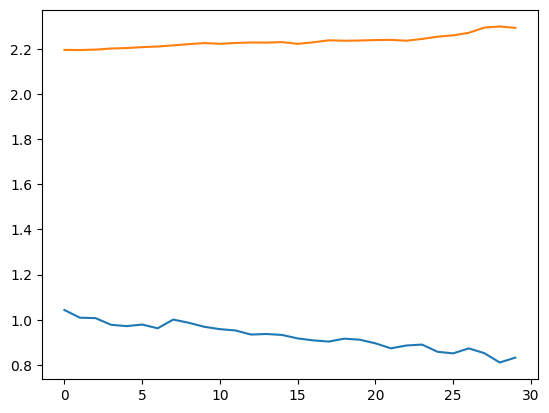

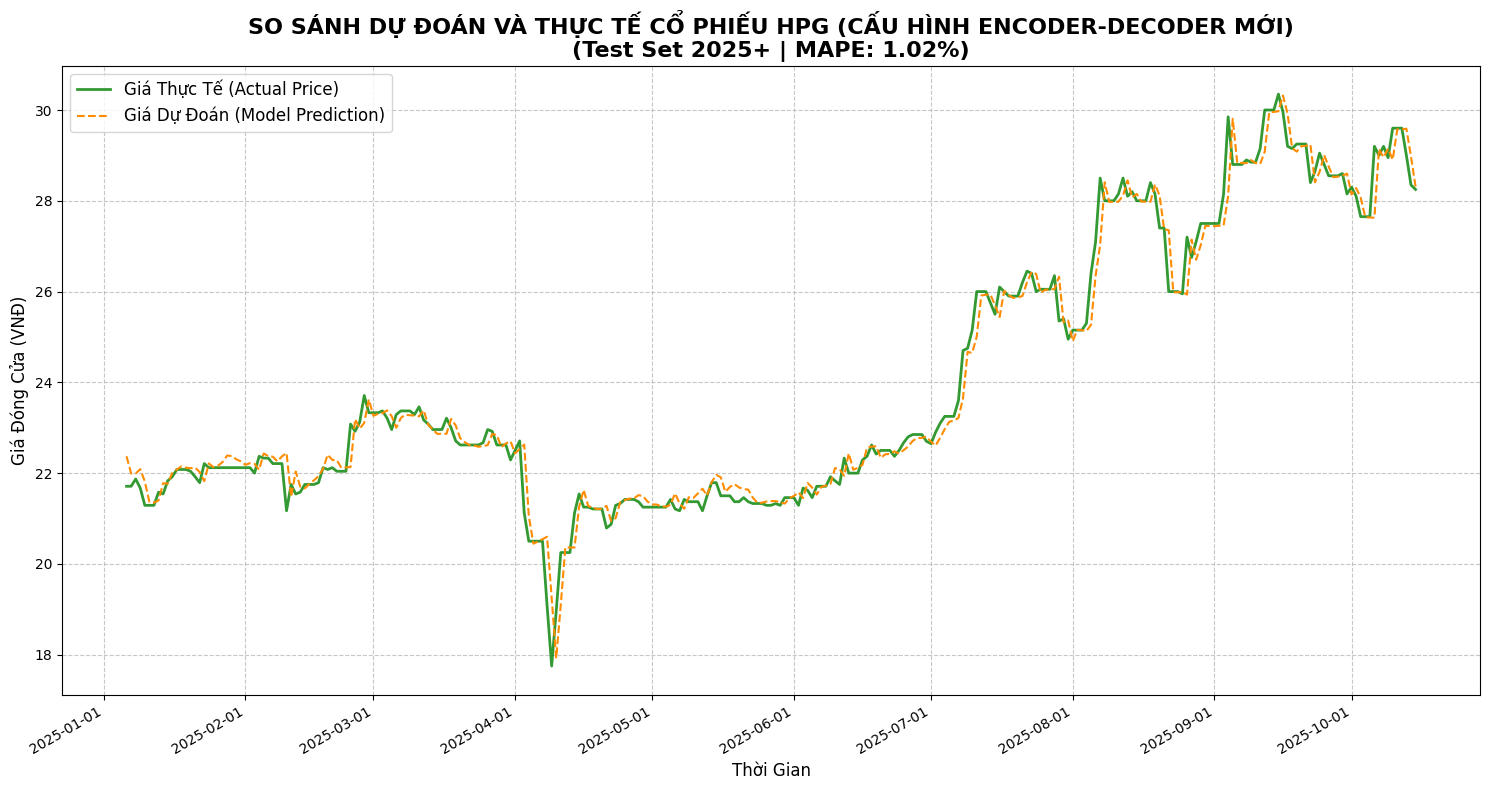


7. Dự đoán giá cho ngày giao dịch tiếp theo...

DỰ ĐOÁN GIÁ TIẾP THEO
Mã cổ phiếu: HPG
Ngày cuối cùng trong dữ liệu: 2025-10-15
Giá đóng cửa cuối cùng: 28 VNĐ
Giá dự đoán cho ngày tiếp theo: 28 VNĐ
Thay đổi: -0 VNĐ (-0.18%)


In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import traceback

# Bỏ qua các cảnh báo không quan trọng
warnings.filterwarnings('ignore')

# =====================================
# PHẦN 1. CHUẨN BỊ VÀ HẰNG SỐ
# =====================================
# Khai báo các hằng số
# TARGET_STOCK_CODE = "FPT"
# ADDITIONAL_SENTIMENT_COMPANIES = ['FRT', 'CMG', 'MWG', 'VIC', 'PLX', 'VCB', 'PNJ', 'FOX']

# TARGET_STOCK_CODE = "GAS"
# RELATED_COMPANIES = ['PVS', 'PVD', 'BSR', 'POW', 'PLX', 'PGS', 'VCB', 'HPG', 'VIC', 'FPT']
# TARGET_STOCK_CODE = "SSI"
# RELATED_COMPANIES = ['VND', 'HCM', 'VCI', 'HPG', 'VCB', 'TCB', 'FPT', 'MSN', 'ELC', 'PAN']
# TARGET_STOCK_CODE = "VCB"
# RELATED_COMPANIES = ['TCB', 'VJC', 'HPG', 'PLX', 'VIC', 'SSI', 'GAS','FPT']
TARGET_STOCK_CODE = "HPG"
RELATED_COMPANIES = ['HSG', 'NKG', 'VHM', 'SMC', 'CTD', 'VCB', 'SSI', 'VIC', 'DIG', 'DBC']
FILE_PATH = f"../data/final/{TARGET_STOCK_CODE}_final.csv"

SYMBOL = TARGET_STOCK_CODE
WINDOW_SIZE = 5 # <--- THAY ĐỔI: Cửa sổ trượt 5 ngày
BATCH_SIZE = 64 # <--- ĐIỀU CHỈNH: Tăng Batch Size để chống Overfitting (Đề xuất trước)
EPOCHS = 30     # <--- ĐIỀU CHỈNH: Giảm Epochs để chống Overfitting (Đề xuất trước)
LEARNING_RATE = 5e-5

# =====================================
# PHẦN 2. XỬ LÝ DATA: TÍNH TIs, ALPHA VÀ TEMPORAL FEATURES
# (GIỮ NGUYÊN LOGIC TÍNH TIs & ALPHA)
# =====================================
# ... (Giữ nguyên các hàm z_score, calculate_missing_technical_indicators, calculate_alpha_features) ...

def z_score(series, window):
    """Tính toán Z-score (chuẩn hóa) của một chuỗi trong cửa sổ lăn."""
    return (series - series.rolling(window=window).mean()) / series.rolling(window=window).std().replace(0, 1e-6)

def calculate_missing_technical_indicators(df):
    """
    Tính toán các chỉ báo kỹ thuật còn thiếu, bao gồm các chỉ báo cần thiết
    cho 5 Alpha mới (RSI, Momentum, SMA_20, OBV, EMA_20_Volume, MACD).
    """
    df = df.copy()

    # 1. BB_Width
    if 'BB_Range' not in df.columns or 'BB_Upper' not in df.columns or 'BB_Lower' not in df.columns:
        df['BB_Upper'] = df['close'].rolling(window=20).mean() + 2 * df['close'].rolling(window=20).std().replace(0, 1e-6)
        df['BB_Lower'] = df['close'].rolling(window=20).mean() - 2 * df['close'].rolling(window=20).std().replace(0, 1e-6)
        df['BB_Range'] = df['BB_Upper'] - df['BB_Lower']

    # 2. SMAs & EMAs (Cần cho Alpha 1, 4, 5)
    if 'SMA_10' not in df.columns:
        df['SMA_10'] = df['close'].rolling(window=10).mean()

    if 'SMA_20' not in df.columns:
        df['SMA_20'] = df['close'].rolling(window=20).mean()

    if 'SMA_50' not in df.columns:
        df['SMA_50'] = df['close'].rolling(window=50).mean()

    if 'EMA_10' not in df.columns:
        df['EMA_10'] = df['close'].ewm(span=10, adjust=False).mean()

    if 'EMA_20' not in df.columns:
        df['EMA_20'] = df['close'].ewm(span=20, adjust=False).mean()

    # 3. Momentum (Cần cho Alpha 3, 5)
    if 'Momentum_3' not in df.columns:
        df['Momentum_3'] = df['close'] - df['close'].shift(3)

    if 'Momentum_5' not in df.columns:
        df['Momentum_5'] = df['close'] - df['close'].shift(5)

    if 'Momentum_10' not in df.columns:
        df['Momentum_10'] = df['close'] - df['close'].shift(10)

    # 4. RSI_14 (Cần cho Alpha 2)
    if 'RSI_14' not in df.columns:
        delta = df['close'].diff()
        gain = delta.where(delta > 0, 0).fillna(0)
        loss = -delta.where(delta < 0, 0).fillna(0)
        avg_gain = gain.ewm(com=13, adjust=False).mean()
        avg_loss = loss.ewm(com=13, adjust=False).mean()
        rs = avg_gain / avg_loss.replace(0, 1e-6)
        df['RSI_14'] = 100 - (100 / (1 + rs))

    # 5. OBV (Cần cho Alpha 4)
    if 'OBV' not in df.columns:
        obv_list = []
        obv = 0
        for i in range(len(df)):
            if i > 0:
                if df['close'].iloc[i] > df['close'].iloc[i-1]:
                    obv += df['volume'].iloc[i]
                elif df['close'].iloc[i] < df['close'].iloc[i-1]:
                    obv -= df['volume'].iloc[i]
            obv_list.append(obv)
        df['OBV'] = obv_list

    # 6. EMA_20_Volume (Cần cho Alpha 3)
    if 'EMA_20_Volume' not in df.columns:
        df['EMA_20_Volume'] = df['volume'].ewm(span=20, adjust=False).mean()

    # 7. MACD (Cần cho Alpha 2)
    if 'MACD' not in df.columns or 'MACD_Signal' not in df.columns:
        ema_12 = df['close'].ewm(span=12, adjust=False).mean()
        ema_26 = df['close'].ewm(span=26, adjust=False).mean()
        df['MACD'] = ema_12 - ema_26
        df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    df = df.fillna(0)

    return df

def load_stock_data_from_df(file_path, symbol):
    print(f"Đang đọc file: {file_path}")
    if not os.path.exists(file_path):
        print(f"LỖI: KHÔNG TÌM THẤY FILE tại đường dẫn: {file_path}")
        return pd.DataFrame()

    try:
        df = pd.read_csv(file_path, encoding='utf-8-sig')
    except UnicodeDecodeError:
        try:
            df = pd.read_csv(file_path, encoding='cp1252')
        except:
            df = pd.read_csv(file_path, encoding='latin-1')

    df.rename(columns={'Thời gian': 'date'}, inplace=True)

    try:
        df['date'] = pd.to_datetime(df['date'], dayfirst=True)
    except:
        df['date'] = pd.to_datetime(df['date'])

    df = df.sort_values('date').reset_index(drop=True)
    start_date = pd.to_datetime('2024-01-01')
    df = df[df['date'] >= start_date].copy()

    if df.empty:
        print("LỖI: Dữ liệu bị rỗng sau khi lọc ngày bắt đầu.")
        return pd.DataFrame()

    print("\n-> Đang kiểm tra và tính toán các Chỉ báo Kỹ thuật còn thiếu...")
    df = calculate_missing_technical_indicators(df)

    print(f"Đã tải {len(df)} dòng dữ liệu")
    return df

def calculate_alpha_features(df):
    """
    Tính toán 5 trường alpha mới cho FPT dựa trên công thức siêu phức tạp mới.
    """
    df = df.copy()
    sentiment_fpt = f'{TARGET_STOCK_CODE}_daily_new_sentiment_score'

    if 'returns' not in df.columns:
        df['returns'] = df['close'].pct_change()
    if 'vwap' not in df.columns:
        # approximate vwap as rolling mean(close*volume)/rolling mean(volume) if volume available
        if 'volume' in df.columns and df['volume'].sum() > 0:
            df['vwap'] = (df['close'] * df['volume']).rolling(10).sum() / df['volume'].rolling(10).sum()
        else:
            df['vwap'] = df['close']
    if 'adv20' not in df.columns:
        df['adv20'] = df['volume'].rolling(20).mean()
        
    # --- CÁC CÔNG THỨC ALPHA MỚI (SIÊU PHỨC TẠP) ---
    # (Giữ nguyên logic tính toán 5 Alpha)

    # --- Convenience aliases ---
    o = df['open']
    h = df['high']
    l = df['low']
    c = df['close']
    v = df['volume']
    vw = df['vwap']

    # --- Hàm phụ trợ ---
    def rank(x):
        """Rank hóa theo từng cột, giá trị nhỏ -> 0, giá trị lớn -> 1"""
        return x.rank(pct=True)

    def ts_rank(x, window):
        """Time-series rank theo cửa sổ lăn"""
        return x.rolling(window).apply(lambda s: s.rank(pct=True).iloc[-1], raw=False)

    def rolling_corr(x, y, window):
        """Tính rolling correlation giữa 2 series"""
        return x.rolling(window).corr(y)

    def ts_max(x, window):
        """Tính max theo cửa sổ lăn"""
        return x.rolling(window).max()

    # Calculate 5 alpha 
    df['alpha1'] = -1.0 * ts_max(rolling_corr(rank(v), rank(vw), 5), 5)
    df['alpha2'] = rank(-1 * ((1 - (o / c))**1))
    df['alpha3'] = -1 * ts_max(rolling_corr(ts_rank(v,5), ts_rank(h,5),3), 3)
    df['alpha4'] = (c - o) / ((h - l) + 0.001)
    df['alpha5'] = rank(vw - c) / rank(vw + c)

    # --- Dọn dẹp và làm sạch ---
    cols_to_drop = [col for col in df.columns if col.endswith('_A1') or col.endswith('_A2') or col.endswith('_A3') or col.endswith('_A4') or col.endswith('_A5')]
    df = df.drop(cols_to_drop, axis=1, errors='ignore')

    df = df.replace([np.inf, -np.inf], 0)
    df = df.fillna(0)

    print("Đã tính toán xong 5 alpha features mới cho FPT.")
    return df

def add_temporal_features(df):
    """
    Tạo các tính năng liên quan đến thời gian (Temporal Features):
    Day of Week (1-5), Day of Month (1-31), Month of Year (1-12)
    """
    df['day_of_week'] = df['date'].dt.dayofweek + 1 # 1=Thứ 2, 5=Thứ 6
    df['day_of_month'] = df['date'].dt.day
    df['month_of_year'] = df['date'].dt.month
    return df

def prepare_data_with_sentiment(df):
    df = df.copy()

    df = calculate_alpha_features(df)
    df = add_temporal_features(df) # <--- THÊM: Tính năng thời gian

    df['Pct_Change'] = df['close'].pct_change() * 100
    df['Pct_Change'] = df['Pct_Change'].fillna(0)

    check_cols = ['SMA_50']

    initial_len = len(df)
    df_cleaned = df[~(df[check_cols] == 0).any(axis=1)].reset_index(drop=True)

    print(f"Sau khi làm sạch: {len(df_cleaned)} dòng dữ liệu (Đã loại bỏ {initial_len - len(df_cleaned)} dòng do thiếu dữ liệu lịch sử).")
    return df_cleaned

def create_sliding_windows(source_data, target_input_data, target_output_data, window_size=5):
    # Giữ nguyên logic cửa sổ trượt
    X_src, X_tgt_in, y = [], [], []
    for i in range(len(source_data) - window_size):
        X_src.append(source_data[i:(i + window_size)])
        X_tgt_in.append(target_input_data[i:(i + window_size)])
        y.append(target_output_data[i + window_size])
    return np.array(X_src), np.array(X_tgt_in), np.array(y)

class StockDataset(Dataset):
    # Giữ nguyên
    def __init__(self, X_src, X_tgt_in, y):
        self.X_src = torch.FloatTensor(X_src)
        self.X_tgt_in = torch.FloatTensor(X_tgt_in)
        self.y = torch.FloatTensor(y)
    def __len__(self):
        return len(self.X_src)
    def __getitem__(self, idx):
        return self.X_src[idx], self.X_tgt_in[idx], self.y[idx]

# =====================================
# PHẦN 3. ĐỊNH NGHĨA MODEL
# =====================================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0) # Shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape: (batch_size, seq_len, d_model)
        # Sửa lỗi: Lấy pe theo seq_len (chiều 1 của x)
        # Sử dụng slicing và không cần .repeat() phức tạp
        x = x + self.pe[:, :x.size(1), :]
        return x

class TemporalEmbedding(nn.Module):
    # Sử dụng Embedding cho các giá trị rời rạc (Day, Month, Year)
    # Vì giờ ta sử dụng các features này trong Dataframe, nên ta sẽ đơn giản hóa nó thành
    # một Conv1D/Linear Layer để xử lý feature đó.
    # Tuy nhiên, để sát với lý thuyết Temporal Embedding, ta sẽ dùng Linear để chiếu lên d_model
    def __init__(self, input_temporal_dim, d_model):
        super(TemporalEmbedding, self).__init__()
        # Giả sử ta dùng 3 temporal features: day_of_week, day_of_month, month_of_year
        self.linear_temporal = nn.Linear(input_temporal_dim, d_model)

    def forward(self, x):
        # x_temporal shape: (batch_size, seq_len, 3)
        # Output shape: (batch_size, seq_len, d_model)
        return self.linear_temporal(x)

class StockEncoderDecoderTransformer(nn.Module):
    def __init__(self, input_dim_src, input_dim_tgt, d_model=128, nhead=8, num_layers=2, dropout=0.2, window_size=5): # <--- THAY ĐỔI: num_layers=2, dropout=0.2, window_size=5
        super(StockEncoderDecoderTransformer, self).__init__()
        self.d_model = d_model
        self.window_size = window_size

        # Số lượng Temporal Features là 3 (day_of_week, day_of_month, month_of_year)
        self.temporal_dim = 3
        # Số lượng Alpha Features là 5 (alpha1-5)
        self.alpha_dim = 5
        # Số lượng Price Features (close) là 1 (close)
        self.price_dim = 1

        # --- Encoder Components (5 Alpha + Temporal) ---
        # 1. Conv Embedding cho Alpha (5 features)
        self.conv_emb_src_alpha = nn.Conv1d(self.alpha_dim, d_model, kernel_size=3, padding=1) # kernel=3, padding=1 cho W=5
        # 2. Temporal Embedding cho Temporal Features (3 features)
        self.temporal_emb_src = TemporalEmbedding(self.temporal_dim, d_model)

        self.pos_encoder = PositionalEncoding(d_model, max_len=window_size)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=512, dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # --- Decoder Components (1 Close Price + Temporal) ---
        # 1. Conv Embedding cho Close Price (1 feature)
        self.conv_emb_tgt_price = nn.Conv1d(self.price_dim, d_model, kernel_size=3, padding=1)
        # 2. Temporal Embedding cho Temporal Features (3 features)
        self.temporal_emb_tgt = TemporalEmbedding(self.temporal_dim, d_model)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=512, dropout=dropout, batch_first=True
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        # --- Prediction Head ---
        self.projection_head = nn.Sequential(
            nn.Linear(d_model * window_size, 256), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(256, 128), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(128, 1)
        )

    def _get_embedding(self, x_data, x_temporal, conv_emb_layer, temporal_emb_layer):
        # x_data: (batch, seq_len, N_data_features)
        # x_temporal: (batch, seq_len, 3)

        # 1. Conv Embedding (Áp dụng cho Data Features: Alpha hoặc Price)
        x_data_conv = x_data.transpose(1, 2) # (batch, N_data_features, seq_len)
        x_conv = conv_emb_layer(x_data_conv) # (batch, d_model, seq_len)
        x_conv = x_conv.transpose(1, 2)      # (batch, seq_len, d_model)

        # 2. Temporal Embedding (Áp dụng cho Temporal Features)
        x_temporal_emb = temporal_emb_layer(x_temporal) # (batch, seq_len, d_model)

        # 3. Kết hợp (Combine)
        # Theo lý thuyết: "Đầu ra từ hai lớp này được kết hợp" -> Summation
        x_emb = x_conv + x_temporal_emb

        # 4. Position Embedding (Thêm vào sau cùng)
        x_final = self.pos_encoder(x_emb) # (batch, seq_len, d_model)
        return x_final

    def forward(self, x_src, x_tgt_in):
        # Tách Alpha (5) và Temporal (3)
        x_src_alpha = x_src[:, :, :self.alpha_dim]
        x_src_temporal = x_src[:, :, self.alpha_dim:]

        # Tách Price (1) và Temporal (3)
        x_tgt_in_price = x_tgt_in[:, :, :self.price_dim]
        x_tgt_in_temporal = x_tgt_in[:, :, self.price_dim:]

        # Encoder Embedding
        src_emb = self._get_embedding(
            x_src_alpha, x_src_temporal,
            self.conv_emb_src_alpha, self.temporal_emb_src
        )
        memory = self.transformer_encoder(src_emb) # (batch, seq_len, d_model)

        # Decoder Embedding
        tgt_emb = self._get_embedding(
            x_tgt_in_price, x_tgt_in_temporal,
            self.conv_emb_tgt_price, self.temporal_emb_tgt
        )
        output = self.transformer_decoder(tgt_emb, memory) # (batch, seq_len, d_model)

        # Prediction Head
        output_flat = output.reshape(output.size(0), -1)
        prediction = self.projection_head(output_flat)
        return prediction

# =====================================
# PHẦN 4. TRAIN & EVALUATE
# =====================================
def train_model(model, train_loader, val_loader, epochs, learning_rate):
    # Đã thêm các điều chỉnh chống overfitting (epochs, batch size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses, val_losses = [], []

    print(f"\nBắt đầu huấn luyện {epochs} epochs...")
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_X_src, batch_X_tgt_in, batch_y in train_loader:
            optimizer.zero_grad()
            predictions = model(batch_X_src, batch_X_tgt_in).squeeze()
            loss = criterion(predictions, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_X_src, batch_X_tgt_in, batch_y in val_loader:
                predictions = model(batch_X_src, batch_X_tgt_in).squeeze()
                loss = criterion(predictions, batch_y)
                val_loss += loss.item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if (epoch + 1) % 5 == 0 or epoch == epochs - 1:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

    return train_losses, val_losses

def predict_next_day(model, scaler_src, scaler_tgt_input, scaler_tgt_output, recent_data, src_cols, tgt_in_cols):
    # Giữ nguyên logic dự đoán nhưng với cửa sổ mới
    if len(recent_data) < WINDOW_SIZE:
        print(f"Lỗi: Cần ít nhất {WINDOW_SIZE} ngày dữ liệu để dự đoán.")
        return None

    last_window_data = recent_data.tail(WINDOW_SIZE)
    last_actual_close = last_window_data['close'].iloc[-1]

    # Chuẩn hóa dữ liệu theo Source và Target Input Scaler
    features_src = last_window_data[src_cols].values
    features_src_scaled = scaler_src.transform(features_src)
    last_window_src_tensor = torch.FloatTensor(features_src_scaled).unsqueeze(0)

    features_tgt_in = last_window_data[tgt_in_cols].values
    features_tgt_in_scaled = scaler_tgt_input.transform(features_tgt_in)
    last_window_tgt_in_tensor = torch.FloatTensor(features_tgt_in_scaled).unsqueeze(0)

    model.eval()
    with torch.no_grad():
        scaled_pct_change_pred = model(last_window_src_tensor, last_window_tgt_in_tensor).item()

    pct_change_pred_unscaled = scaler_tgt_output.inverse_transform(np.array([[scaled_pct_change_pred]]))[0, 0]
    predicted_price = last_actual_close * (1 + pct_change_pred_unscaled / 100)

    return predicted_price

# =====================================
# PHẦN 5. MAIN EXECUTION
# =====================================
def main(file_path, symbol):
    print(f"=== DỰ BÁO GIÁ CỔ PHIẾU {symbol} BẰNG TRANSFORMER ENCODER-DECODER (CẤU HÌNH MỚI) ===")
    print(f"=== Cấu hình: Window Size={WINDOW_SIZE}, Encoder Input: 5 Alpha + Temporal | Decoder Input: Close + Temporal ===")

    print("\n1. Đang tải và xử lý dữ liệu...")
    df = load_stock_data_from_df(file_path, symbol)
    if df.empty:
        return None

    df_processed = prepare_data_with_sentiment(df)

    # Định nghĩa các cột Features mới theo lý thuyết
    temporal_columns = ['day_of_week', 'day_of_month', 'month_of_year']
    alpha_columns = ['alpha1', 'alpha2', 'alpha3', 'alpha4', 'alpha5']

    # Encoder Input: 5 Alpha + Temporal Features (5 + 3 = 8 features)
    source_columns = alpha_columns + temporal_columns
    # Decoder Input: Close Price + Temporal Features (1 + 3 = 4 features)
    target_input_columns = ['close'] + temporal_columns
    target_output_column = 'Pct_Change'

    source_columns = [col for col in source_columns if col in df_processed.columns]
    target_input_columns = [col for col in target_input_columns if col in df_processed.columns]

    if len(source_columns) != 8:
        print(f"\nLỖI: Thiếu cột Encoder Input. Chỉ tìm thấy {len(source_columns)}/8.")
        return None
    if len(target_input_columns) != 4:
        print(f"\nLỖI: Thiếu cột Decoder Input. Chỉ tìm thấy {len(target_input_columns)}/4.")
        return None

    print(f"Tổng số ngày dữ liệu sau khi làm sạch: {len(df_processed)}")
    print(f"SỐ LƯỢNG FEATURES ENCODER: {len(source_columns)} (5 Alpha + 3 Temporal)")
    print(f"SỐ LƯỢNG FEATURES DECODER INPUT: {len(target_input_columns)} (1 Close + 3 Temporal)")

    # --- CHIA TRAIN/TEST THEO NGÀY ---
    TRAIN_START_DATE = pd.to_datetime('2024-01-01')
    TRAIN_END_DATE = pd.to_datetime('2024-12-31')
    TEST_START_DATE = pd.to_datetime('2025-01-01')

    df_train = df_processed[
        (df_processed['date'] >= TRAIN_START_DATE) &
        (df_processed['date'] <= TRAIN_END_DATE)
    ].copy()

    df_test = df_processed[
        (df_processed['date'] >= TEST_START_DATE)
    ].copy()

    # ... (Kiểm tra dữ liệu Train/Test) ...

    # --- TẠO CỬA SỔ TRƯỢT VÀ CHUẨN HÓA DỮ LIỆU ---
    print("\n3. Đang tạo cửa sổ trượt và chuẩn hóa dữ liệu...")
    X_src_train_raw, X_tgt_in_train_raw, y_train_raw = create_sliding_windows(
        df_train[source_columns].values,
        df_train[target_input_columns].values,
        df_train[target_output_column].values,
        WINDOW_SIZE
    )

    X_src_test_raw, X_tgt_in_test_raw, y_test_raw = create_sliding_windows(
        df_test[source_columns].values,
        df_test[target_input_columns].values,
        df_test[target_output_column].values,
        WINDOW_SIZE
    )

    test_dates = df_test['date'].dt.date.values[WINDOW_SIZE:]

    # Chuẩn hóa dữ liệu Source và Target Input
    scaler_src = StandardScaler()
    X_src_train = scaler_src.fit_transform(X_src_train_raw.reshape(-1, len(source_columns))).reshape(X_src_train_raw.shape)
    X_src_test = scaler_src.transform(X_src_test_raw.reshape(-1, len(source_columns))).reshape(X_src_test_raw.shape)

    scaler_tgt_input = StandardScaler()
    X_tgt_in_train = scaler_tgt_input.fit_transform(X_tgt_in_train_raw.reshape(-1, len(target_input_columns))).reshape(X_tgt_in_train_raw.shape)
    X_tgt_in_test = scaler_tgt_input.transform(X_tgt_in_test_raw.reshape(-1, len(target_input_columns))).reshape(X_tgt_in_test_raw.shape)

    # Chuẩn hóa Target Output
    scaler_tgt_output = StandardScaler()
    y_train = scaler_tgt_output.fit_transform(y_train_raw.reshape(-1, 1)).squeeze()
    y_test = scaler_tgt_output.transform(y_test_raw.reshape(-1, 1)).squeeze()

    print(f"Train samples (đã tạo window): {len(X_src_train)}")
    print(f"Test samples (đã tạo window): {len(X_src_test)}")

    # Tạo DataLoader
    train_loader = DataLoader(StockDataset(X_src_train, X_tgt_in_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(StockDataset(X_src_test, X_tgt_in_test, y_test), batch_size=BATCH_SIZE, shuffle=False)

    # Định nghĩa và Train Model
    print(f"\n4. Đang khởi tạo và huấn luyện mô hình (d_model=128, nhead=8, num_layers=2, dropout=0.2)...")
    model = StockEncoderDecoderTransformer(
        input_dim_src=len(source_columns),
        input_dim_tgt=len(target_input_columns),
        d_model=128,
        nhead=8,
        num_layers=2, # <--- ĐIỀU CHỈNH: Giảm lớp để chống Overfitting
        dropout=0.2,  # <--- ĐIỀU CHỈNH: Tăng dropout để chống Overfitting
        window_size=WINDOW_SIZE
    )
    train_losses, val_lossses = train_model(model, train_loader, test_loader, epochs=EPOCHS, learning_rate=LEARNING_RATE)

    # Đánh giá cuối cùng trên Test set
    # ... (Giữ nguyên logic đánh giá và tính lỗi) ...
    print("\n5. Đang đánh giá trên tập Test...")
    model.eval()
    predictions_scaled = []
    with torch.no_grad():
        for batch_X_src, batch_X_tgt_in, _ in test_loader:
            batch_pred = model(batch_X_src, batch_X_tgt_in).squeeze()
            if batch_pred.dim() == 0:
                predictions_scaled.append(batch_pred.item())
            else:
                predictions_scaled.extend(batch_pred.cpu().numpy().tolist())

    # Inverse Transform Pct_Change
    pct_change_pred_unscaled = scaler_tgt_output.inverse_transform(np.array(predictions_scaled).reshape(-1, 1)).squeeze()
    y_test_unscaled = scaler_tgt_output.inverse_transform(y_test.reshape(-1, 1)).squeeze()

    # Tính lại giá trị tuyệt đối từ Pct_Change
    close_price_T_minus_1 = df_test['close'].iloc[WINDOW_SIZE-1:-1].values # Giá đóng cửa ngày T-1

    min_len = min(len(close_price_T_minus_1), len(pct_change_pred_unscaled))
    close_price_T_minus_1 = close_price_T_minus_1[:min_len]
    pct_change_pred_unscaled = pct_change_pred_unscaled[:min_len]
    y_test_unscaled = y_test_unscaled[:min_len]
    test_dates = test_dates[:min_len]

    # Giá dự đoán ngày T = Giá T-1 * (1 + Pct_Change T / 100)
    predictions_unscaled = close_price_T_minus_1 * (1 + pct_change_pred_unscaled / 100)
    actuals_unscaled = df_test['close'].iloc[WINDOW_SIZE:WINDOW_SIZE+min_len].values # Giá đóng cửa thực tế ngày T

    # Tính toán lỗi
    mse = mean_squared_error(actuals_unscaled, predictions_unscaled)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actuals_unscaled - predictions_unscaled) / (actuals_unscaled + 1e-6))) * 100

    print("\n" + "="*90)
    print(f"KẾT QUẢ ĐÁNH GIÁ TRÊN TẬP TEST ({symbol}: CẤU HÌNH THEO LÝ THUYẾT ENCODER-DECODER MỚI)")
    print("="*90)
    print(f"Cấu hình: Window={WINDOW_SIZE}, d_model=128, Encoder (5 Alpha + Temporal), Decoder (Close + Temporal)")
    print(f"MSE:  {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print("="*90)

    results = {
        "model": model,
        "df_processed": df_processed,
        "test_dates": test_dates,
        "predictions_unscaled": predictions_unscaled,
        "actuals_unscaled": actuals_unscaled,
        "train_losses": train_losses, 
        "val_losses": val_lossses,
        "scalers": {
            "src": scaler_src,
            "tgt_input": scaler_tgt_input,
            "tgt_output": scaler_tgt_output
        },
        "columns": {
            "source": source_columns,
            "target_input": target_input_columns
        },
        "metrics": {
            "mse": mse,
            "rmse": rmse,
            "mape": mape
        }
    }
    return results

# =====================================
# PHẦN 6. VẼ BIỂU ĐỒ SO SÁNH
# =====================================
def plot_predictions_vs_actuals(test_dates, predictions, actuals, symbol, mape):
    # Giữ nguyên logic vẽ đồ thị
    min_len = min(len(test_dates), len(actuals), len(predictions))
    test_dates = test_dates[:min_len]
    actuals = actuals[:min_len]
    predictions = predictions[:min_len]

    plt.figure(figsize=(15, 8))
    try:
        dates_for_plot = [datetime.combine(d, datetime.min.time()) for d in test_dates]
    except TypeError:
        dates_for_plot = test_dates

    plt.plot(dates_for_plot, actuals, label='Giá Thực Tế (Actual Price)', color='green', linewidth=2, alpha=0.8)
    plt.plot(dates_for_plot, predictions, label='Giá Dự Đoán (Model Prediction)', color='darkorange', linestyle='--', linewidth=1.5)

    plt.title(f'SO SÁNH DỰ ĐOÁN VÀ THỰC TẾ CỔ PHIẾU {symbol} (CẤU HÌNH ENCODER-DECODER MỚI)\n(Test Set 2025+ | MAPE: {mape:.2f}%)', fontsize=16, fontweight='bold')
    plt.xlabel('Thời Gian', fontsize=12)
    plt.ylabel('Giá Đóng Cửa (VNĐ)', fontsize=12)

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gcf().autofmt_xdate()

    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# =====================================
# THỰC THI CHÍNH
# =====================================
if __name__ == '__main__':
    try:
        training_results = main(FILE_PATH, SYMBOL)
        plt.plot(training_results["train_losses"])
        plt.plot(training_results['val_losses'])
        if training_results:
            print("\n6. Đang vẽ biểu đồ kết quả...")
            plot_predictions_vs_actuals(
                test_dates=training_results["test_dates"],
                predictions=training_results["predictions_unscaled"],
                actuals=training_results["actuals_unscaled"],
                symbol=SYMBOL,
                mape=training_results["metrics"]["mape"]
            )

            print("\n7. Dự đoán giá cho ngày giao dịch tiếp theo...")
            next_day_price = predict_next_day(
                model=training_results["model"],
                scaler_src=training_results["scalers"]["src"],
                scaler_tgt_input=training_results["scalers"]["tgt_input"],
                scaler_tgt_output=training_results["scalers"]["tgt_output"],
                recent_data=training_results["df_processed"],
                src_cols=training_results["columns"]["source"],
                tgt_in_cols=training_results["columns"]["target_input"]
            )

            if next_day_price is not None:
                last_date = training_results["df_processed"]['date'].iloc[-1].date()
                last_price = training_results['df_processed']['close'].iloc[-1]
                price_change = next_day_price - last_price
                change_percent = (price_change / last_price) * 100

                print("\n" + "="*50)
                print("DỰ ĐOÁN GIÁ TIẾP THEO")
                print("="*50)
                print(f"Mã cổ phiếu: {SYMBOL}")
                print(f"Ngày cuối cùng trong dữ liệu: {last_date}")
                print(f"Giá đóng cửa cuối cùng: {last_price:,.0f} VNĐ")
                print(f"Giá dự đoán cho ngày tiếp theo: {next_day_price:,.0f} VNĐ")
                print(f"Thay đổi: {price_change:+,.0f} VNĐ ({change_percent:+.2f}%)")
                print("="*50)
    except Exception as e:
        print(f"\nLỖI CHƯƠNG TRÌNH: Đã xảy ra lỗi không mong muốn trong quá trình thực thi: {e}")
        traceback.print_exc()